## Filter out guides that are multi-targeting

Run this script after: `align_guides.R`

**Input:**  
- Guide alignment file computed in `align_guides.R`
- Guide level log-fold changes file downloaded from DepMap
- HGNC gene ID map

**Output:**  
* Filtered version of the log-fold changes file - input for CERES (run this notebook before `run_CERES.R` script).
* Guides per gene

Notes: 
- Using hg19/GRCh37 reference human genome - DepMap does alignment to GRCh38 from v. 19Q3, this is mentioned in Tsherniak et al (2019) https://www.biorxiv.org/content/10.1101/720243v1.full
- Guides that have > 100 alignments are not used by CERES.  
- Definitions of "PAM-distal" are taken from Fortin et al (2019): https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1621-7

In [397]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update({'font.size': 12, 'axes.spines.top': False, 'axes.spines.right': False})

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

perfect_alignment = 20

# Input from DepMap
file_logfold_changes = get_data_path(['depmap', '19Q1'], 'logfold_change.csv')
file_guide_map = get_data_path(['depmap', '19Q1'], 'guide_gene_map.csv')

# Input from R script
file_alignments = get_local_data_path(['processed', 'depmap19Q1'], 'guide_alignments_hg19.csv')

# Other input 
file_id_map = get_data_path(['HGNC'] , 'non_alt_loci_set_01_02_19.txt')

# Output
file_filtered_lfc = get_local_data_path(['processed', 'depmap19Q1'], 'filtered_lfc_11_07_19.csv')
file_guides_per_gene = get_local_data_path(['processed', 'depmap19Q1'], 'guides_per_gene_11_07_19.csv')
file_gene_guide_status = get_local_data_path(['processed', 'depmap19Q1'], 'gene_sgrna_status.csv')

### Load alignments computed in R script + DepMap guide map

In [201]:
# Load and clean the alignment file generated in R notebook
raw_alignments = pd.read_csv(file_alignments)
print('N=', raw_alignments.shape[0])
display(raw_alignments[:1])

N= 100024


,sgrna,chr,cut_pos,strand,alignment,gene,geneID,CDS_strand,CDS_start,CDS_end
0,AAAAAAATCCAGCAATGCAG,chr10,112724378,+,20,SHOC2,8036,+,112724116,112724818


In [203]:
# Duplicates: different CDS_start and CDS_end (multiple exons) - only considering gene level
alignments = raw_alignments.drop_duplicates(subset=['sgrna', 'gene', 'geneID', 'alignment'])
alignments = alignments.rename(columns={'geneID':'entrez_id'})
alignments = alignments[['sgrna', 'alignment', 'entrez_id', 'gene', 'chr', 'strand', 'cut_pos']]
alignments = alignments.sort_values('gene')

print('N=', alignments.shape[0])
print('# of guides:', alignments.sgrna.nunique())

# Check there is no alignment to X and Y chromosomes
assert(alignments[(alignments.chr == 'chrX') | (alignments.chr == 'chrY')].shape[0] == 0)
alignments[:1]

N= 93800
# of guides: 69988


,sgrna,alignment,entrez_id,gene,chr,strand,cut_pos
79111,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58863833


### 1. Determine alignment types
Drop alignments for guides w/ 0 perfect matches.  
Drop non-PAM-distal double mismatch alignments (don't consider these).

In [204]:
# Calculate alignment type based on the 'alignment' encoding 
# PAM-distal = in the 10 nucleotides furthest from the PAM for single mismatch
# PAM-distal = in the 2 nucleotides furthest from the PAM for double mismatch
def get_alignment_type(row):
    if row.alignment == str(perfect_alignment):
        return 'perfect'
    match = re.search('^(\d+)[ATCG]\d+$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(1)) <= 9) or 
            (row.strand == '-' and int(match.group(1)) >= (perfect_alignment-9))):
            return 'pam_distal_single'
        return 'single'
    match = re.search('^(\d+)[ATCG](\d+)[ATCG](\d+)$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(3)) == (perfect_alignment-2)) or 
            (row.strand == '-' and int(match.group(1)) == (perfect_alignment-2))):
            return 'pam_distal_double'
        return 'double'
    
alignments_w_type = alignments.assign(align_type = alignments.apply(get_alignment_type, axis=1))
alignments_w_type = alignments_w_type.rename(columns={'gene':'symbol','geneID':'entrez_id'}).astype({'entrez_id':'str'})

In [205]:
alignments_w_type[:2]

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type
79111,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58863833,perfect
78739,GTGGACTTCCAGCTACGGCG,20,1,A1BG,chr19,-,58862935,perfect


In [206]:
# Drop guides w no perfect alignment: these will also be dropped by CERES
w_perfect_match = alignments_w_type[alignments_w_type.align_type == 'perfect'].sgrna.unique()
print('# of guides w/out a perfect alignment (these are ignored):', 
        alignments_w_type[~alignments_w_type.sgrna.isin(w_perfect_match)].sgrna.nunique())

alignments_w_perfect_match = alignments_w_type[alignments_w_type.sgrna.isin(w_perfect_match)].reset_index(drop=True)

# of guides w/out a perfect alignment (these are ignored): 293


In [207]:
alignments_w_perfect_match[:2]

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58863833,perfect
1,GTGGACTTCCAGCTACGGCG,20,1,A1BG,chr19,-,58862935,perfect


### 2. Determine locus types

# of genes targeted: 17788


,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,locus_type
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58863833,perfect,gene with protein product


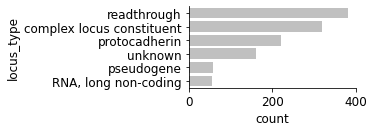

In [338]:
# Add locus info, e.g. read-through gene
id_map = pd.read_csv(file_id_map, sep='\t', low_memory=False)[['locus_type', 'entrez_id']]
id_map = id_map.dropna(subset=['entrez_id']).astype({'entrez_id':'int'}).astype({'entrez_id':'str'})
alignments_w_locus_type = pd.merge(alignments_w_perfect_match, id_map, how='left')

# Look at genes that are not classified as "gene with protein product"
f, ax = plt.subplots(1, 1, figsize=(3,1.5))
df = alignments_w_locus_type[alignments_w_locus_type.locus_type!='gene with protein product']
_=sns.countplot(data=df, y='locus_type', ax=ax, color='silver', order=df['locus_type'].value_counts().index)

print('# of genes targeted:', alignments_w_locus_type.symbol.nunique())
alignments_w_locus_type[:1]

### 3. Cross reference with DepMap guide map

In [339]:
# Cross reference with DepMap guide map - this would only include perfect alignments
depmap_guide_map = pd.read_csv(file_guide_map)
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
get_gene_symbol = lambda x: re.search('([\w-]+)\s\(\w+\)', x).group(1)
depmap_guide_map = depmap_guide_map[~depmap_guide_map.gene.isna()]
depmap_guide_map['symbol'] = depmap_guide_map.gene.apply(get_gene_symbol)
depmap_guide_map['entrez_id'] = depmap_guide_map.gene.apply(get_gene_id)
print('DepMap guide gene map # of genes:', depmap_guide_map.symbol.nunique())
print('DepMap guide gene map # of guides:', depmap_guide_map.sgrna.nunique())

# Exclude X/Y chr genes - I didn't align to those
depmap_guide_map = depmap_guide_map[~depmap_guide_map.genome_alignment.str.startswith('chrX') & 
                                    ~depmap_guide_map.genome_alignment.str.startswith('chrY')]
display(depmap_guide_map[:1])

# The only DepMap entries not in my map are for GCOM1, which HGNC classifies as a readthrough gene
df = pd.merge(alignments_w_locus_type[(alignments_w_locus_type.align_type=='perfect') &
                                      (alignments_w_locus_type.locus_type != 'readthrough')], 
              depmap_guide_map[['sgrna', 'entrez_id', 'gene', 'genome_alignment']], how='outer', on=['sgrna', 'entrez_id'])
print('Alignments not reported by me:', df[df.symbol.isna()].shape[0])
print(df[df.symbol.isna()].gene.unique())
#display(df[df.symbol.isna()])
print('Alignments not reported by DepMap:', df[df.gene.isna()].shape[0])
print(df[df.gene.isna()].symbol.unique())
#df[df.gene.isna()][['sgrna','chr','cut_pos','symbol','entrez_id','align_type','locus_type']]

DepMap guide gene map # of genes: 17733
DepMap guide gene map # of guides: 69653


,sgrna,genome_alignment,gene,n_alignments,symbol,entrez_id
0,AAAAAAATCCAGCAATGCAG,chr10_112724378_+,SHOC2 (8036),1,SHOC2,8036


Alignments not reported by me: 4
['GCOM1 (145781)']
Alignments not reported by DepMap: 32
['ADRA1A' 'ARGFX' 'ARHGAP8' 'B3GALNT2' 'C14orf178' 'CCNJL' 'ERCC6-PGBD3'
 'MYL10' 'NANOGNB' 'PTPRC' 'SUN3' 'TIGD1' 'TNFRSF9' 'TPCN1' 'TSPAN16'
 'ZNF283' 'ZNF431' 'ZNF493']


### 4. Find guides that should be filtered out
* Guides that map to readthrough genes (based on HGNC annotation)
* Guides that map to more than one genes: perfect match or w/ single or PAM-distal double mismatch  

In [398]:
# Don't consider (non-PAM-distal) double mismatches
alignments_to_test = alignments_w_locus_type[(alignments_w_locus_type.align_type != 'double')]

# Identify guides targeting read-through genes
readthrough_guides = alignments_to_test[alignments_to_test.locus_type=='readthrough'].sgrna.unique()
alignments_filtered = alignments_to_test[~alignments_to_test.sgrna.isin(readthrough_guides)].reset_index(drop=True)
print('N readthrough guides:', len(readthrough_guides))

# Annotate guides with number of alignments
num_alns = alignments_filtered.groupby('sgrna').entrez_id.count().reset_index().rename(columns={'entrez_id':'n_alignments'})
alignments_filtered = pd.merge(alignments_filtered, num_alns)

# Filter out multi-targeting guides
guides_w_multiple_matches = alignments_filtered[alignments_filtered.n_alignments > 1].sgrna.unique()
print('Guides w/ multiple alignments:', len(guides_w_multiple_matches))
unique_alignments = alignments_filtered[~alignments_filtered.sgrna.isin(guides_w_multiple_matches)]

dropped_guides = pd.concat([pd.Series(readthrough_guides), pd.Series(guides_w_multiple_matches)]).drop_duplicates()
print('N dropped guides:', len(dropped_guides))

N readthrough guides: 348
Guides w/ multiple alignments: 3287
N dropped guides: 3635


In [399]:
# Save out info on which genes are targeted by min 1 multi-targeting guide
gene_status = alignments_to_test[['sgrna','symbol','entrez_id']]\
                    .assign(multi_target_sgrna = alignments_to_test.sgrna.isin(dropped_guides))
gene_status = gene_status.groupby('entrez_id').multi_target_sgrna.max().reset_index()
display(gene_status[:2])
gene_status.to_csv(file_gene_guide_status, index=0)

,entrez_id,multi_target_sgrna
0,1,False
1,10,True


In [400]:
# Save out guides per gene to use in CERES post-processing
guides_per_gene = unique_alignments.groupby(['symbol', 'entrez_id']).sgrna.nunique().reset_index()
guides_per_gene = guides_per_gene.rename(columns={'sgrna':'guides_per_gene'})
guides_per_gene.to_csv(file_guides_per_gene)
print('Map size:', guides_per_gene.shape[0])
guides_per_gene[:2]

Map size: 17270


,symbol,entrez_id,guides_per_gene
0,A1BG,1,4
1,A1CF,29974,4


### Filter LFC file

In [401]:
orig_lfc = pd.read_csv(file_logfold_changes, index_col=0)
display(orig_lfc[:1])
print('Num guides:', orig_lfc.shape[0])

,127399-311Cas9_RepA_p5_batch3,127399-311Cas9_RepB_p5_batch3,143B-311Cas9_RepA_p6_batch3,2313287-311Cas9_RepA_p5_batch3,2313287-311Cas9_RepB_p5_batch3,253J-311Cas9_RepA_p5_batch3,42-MG-BA-311Cas9_RepA_p6_batch3,42-MG-BA-311Cas9_RepB_p6_batch3,5637-311Cas9_RepA_p6_batch3,5637-311Cas9_RepB_p6_batch3,...,YD38-311Cas9_RepA_p6_batch3,YD38-311Cas9_RepB_p6_batch3,YD8-311Cas9_RepA_p6_batch3,YD8-311Cas9_RepB_p6_batch3,YH-13-311Cas9_RepA_p6_batch3,YH-13-311Cas9_RepB_p6_batch3,YKG1-311Cas9_RepA_p6_batch3,YKG1-311Cas9_RepB_p6_batch3,ZR-75-1-311Cas9_RepA_p5_batch2,ZR-75-1-311Cas9_RepB_p5_batch2
AAAAAAATCCAGCAATGCAG,0.02478,0.062549,0.342181,0.225402,-0.46933,-0.159302,-1.013477,-0.377563,-0.520406,0.065641,...,-0.339174,-1.029635,-0.879435,-0.367176,-0.43021,0.048204,-0.026107,-0.090458,-0.969551,-0.26172


Num guides: 73839


In [403]:
filtered_lfc = orig_lfc[~orig_lfc.index.isin(dropped_guides)]
print('Filtered lfc:', filtered_lfc.shape[0])
display(filtered_lfc[:1])

Filtered lfc: 70204


,127399-311Cas9_RepA_p5_batch3,127399-311Cas9_RepB_p5_batch3,143B-311Cas9_RepA_p6_batch3,2313287-311Cas9_RepA_p5_batch3,2313287-311Cas9_RepB_p5_batch3,253J-311Cas9_RepA_p5_batch3,42-MG-BA-311Cas9_RepA_p6_batch3,42-MG-BA-311Cas9_RepB_p6_batch3,5637-311Cas9_RepA_p6_batch3,5637-311Cas9_RepB_p6_batch3,...,YD38-311Cas9_RepA_p6_batch3,YD38-311Cas9_RepB_p6_batch3,YD8-311Cas9_RepA_p6_batch3,YD8-311Cas9_RepB_p6_batch3,YH-13-311Cas9_RepA_p6_batch3,YH-13-311Cas9_RepB_p6_batch3,YKG1-311Cas9_RepA_p6_batch3,YKG1-311Cas9_RepB_p6_batch3,ZR-75-1-311Cas9_RepA_p5_batch2,ZR-75-1-311Cas9_RepB_p5_batch2
AAAAAAATCCAGCAATGCAG,0.02478,0.062549,0.342181,0.225402,-0.46933,-0.159302,-1.013477,-0.377563,-0.520406,0.065641,...,-0.339174,-1.029635,-0.879435,-0.367176,-0.43021,0.048204,-0.026107,-0.090458,-0.969551,-0.26172


In [70]:
filtered_lfc.to_csv(file_filtered_lfc)

### Visualization

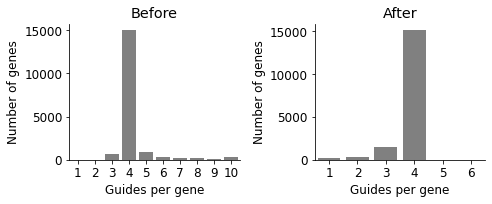

In [10]:
# Guides per gene before and after filtering
def plot_guides_per_gene(guide_map, ax):
    guides_per_gene = pd.DataFrame(guide_map.groupby('entrez_id').sgrna.count())
    guides_per_gene = guides_per_gene.assign(counts = guides_per_gene.sgrna.apply(lambda x: 10 if x>=10 else x))
    sns.countplot(guides_per_gene.counts, ax=ax, color='grey')
    ax.set_xlabel('Guides per gene'); ax.set_ylabel('Number of genes')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
plot_guides_per_gene(alignments_to_test, ax1)
plot_guides_per_gene(unique_alignments, ax2)
ax1.set_title('Before'); ax2.set_title('After'); plt.tight_layout()